### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('../hydrogel.soft.stiff.saha.ppr.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

#data=data[rowSums(data)>0,]


In [3]:
head(data)

,X100Pa_3D_ppr1,X100Pa_3D_ppr2,X2000Pa_3D_ppr1,X2000Pa_3D_ppr2,saha_100Pa_ppr1,saha_100Pa_ppr2,saha_2000Pa_ppr1,saha_2000Pa_ppr2
chr1_713708_714452,32,19,36,28,47,84,75,69
chr1_762643_763047,2,10,9,5,12,16,21,10
chr1_802987_803295,11,14,3,4,23,17,25,17
chr1_804984_805589,6,11,8,12,17,10,31,26
chr1_834765_835239,28,39,18,13,9,5,20,27
chr1_839144_839717,33,34,32,26,9,14,36,28


In [4]:
#load the metadata
batches=read.table("../batches_hydrogel.soft.stiff.saha.ppr.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [5]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_ppr1,Soft,No,100Pa
X100Pa_3D_ppr2,Soft,No,100Pa
X2000Pa_3D_ppr1,Stiff,No,2000Pa
X2000Pa_3D_ppr2,Stiff,No,2000Pa
saha_100Pa_ppr1,Soft,Yes,saha_100Pa
saha_100Pa_ppr2,Soft,Yes,saha_100Pa
saha_2000Pa_ppr1,Stiff,Yes,saha_2000Pa
saha_2000Pa_ppr2,Stiff,Yes,saha_2000Pa


## Soft vs Stiff Analysis 


In [6]:
soft_stiff_data=data[,1:4]
soft_stiff_batches=batches[1:4,]

In [7]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_ppr1,X100Pa_3D_ppr2,X2000Pa_3D_ppr1,X2000Pa_3D_ppr2
chr1_713708_714452,32,19,36,28
chr1_762643_763047,2,10,9,5
chr1_802987_803295,11,14,3,4
chr1_804984_805589,6,11,8,12
chr1_834765_835239,28,39,18,13
chr1_839144_839717,33,34,32,26


,Stiffness,Saha,Sample
X100Pa_3D_ppr1,Soft,No,100Pa
X100Pa_3D_ppr2,Soft,No,100Pa
X2000Pa_3D_ppr1,Stiff,No,2000Pa
X2000Pa_3D_ppr2,Stiff,No,2000Pa


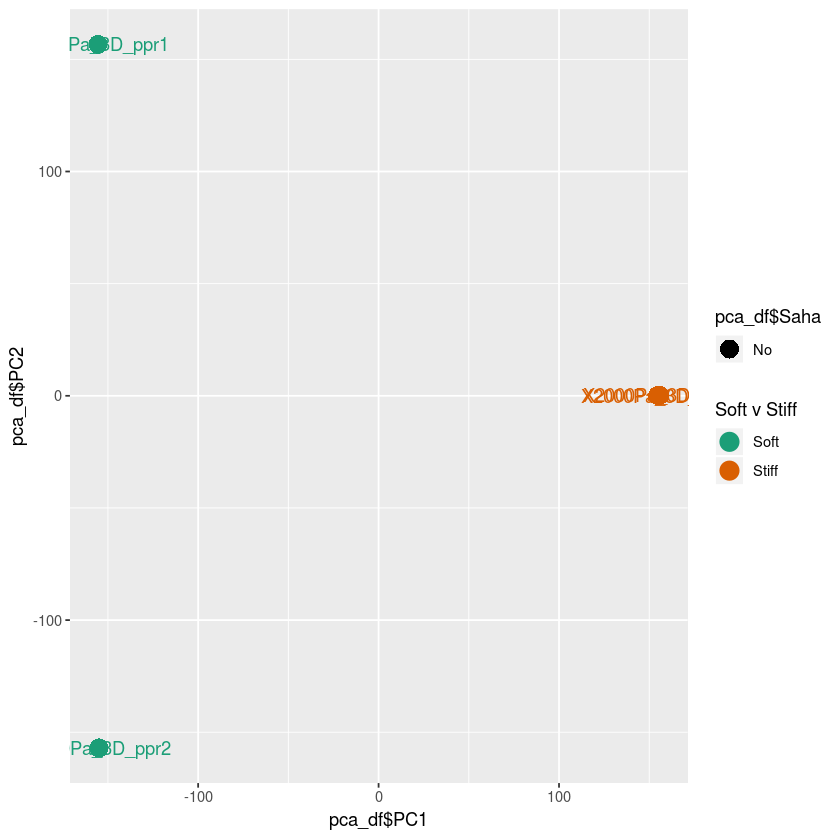

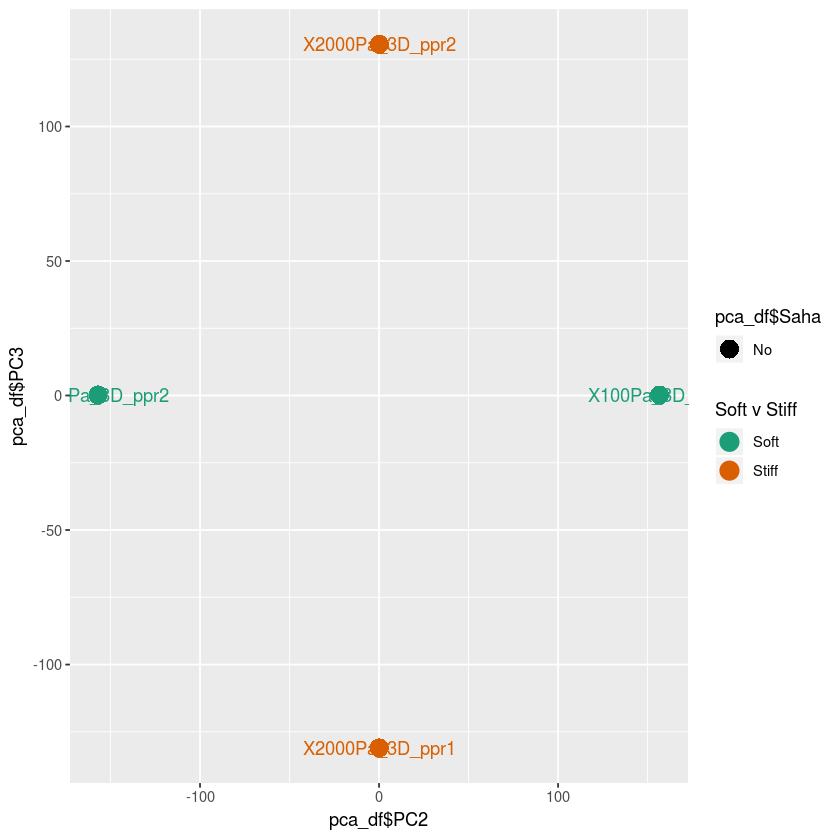

In [8]:
#PCA on shifted log of normalized counts
normcounts=soft_stiff_data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [9]:
pc1_loadings=sort(data.pca$rotation[, 1])
    upper_bound=mean(pc1_loadings)+2*sd(pc1_loadings)
    toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))
    heatmap_indices=match(toselect,rownames(lognc))
    head(heatmap_indices)
    forheatmap=lognc[heatmap_indices,]
    outfname=paste("pc1.nosv.soft.stiff.highest.",2,'.tsv',sep='')
    write.table(forheatmap,file=outfname,row.names=TRUE,col.names=TRUE,sep='\t')

[1] 131181  70316 215677 182814  63001  72766

In [10]:
#Surrogate Variable Analysis 
soft_stiff_data=soft_stiff_data[rowSums(soft_stiff_data)>0,]
mod0=model.matrix(~1,data=soft_stiff_batches)
mod1=model.matrix(~Stiffness,data=soft_stiff_batches)
sva.obj=svaseq(as.matrix(soft_stiff_data),mod1,mod0)


Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

In [11]:
sur_var=data.frame(sva.obj$sv)
names(sur_var)=c("sv1")
soft_stiff_batches=cbind(soft_stiff_batches,sur_var)

In [12]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = soft_stiff_data,
                              colData = soft_stiff_batches,
                              design = ~Stiffness+sv1)


In [13]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("../background/hydrogel.soft.stiff.saha.HK.txt",header=FALSE,sep='\t')
hk_promoters=paste(hk_promoters[,1],hk_promoters[,2],hk_promoters[,3],sep="_")
soft_stiff_hk_promoter_indices=match(hk_promoters,rownames(soft_stiff_data))
head(soft_stiff_hk_promoter_indices)

[1] 15 63 70 71 71 78

In [14]:
dds <- estimateSizeFactors(dds, controlGenes=soft_stiff_hk_promoter_indices)

## Extract and store normalized counts for further analysis 

In [15]:
normcounts=counts(dds,normalized=TRUE)

#use limma's removeBatchEffect function 
tokeep=model.matrix(~Stiffness,data=soft_stiff_batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(soft_stiff_batches,select=c("sv1")))


write.table(normcounts,"soft_stiff_normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [16]:
head(normcounts)

,X100Pa_3D_ppr1,X100Pa_3D_ppr2,X2000Pa_3D_ppr1,X2000Pa_3D_ppr2
chr1_713708_714452,22.646781,22.646434,39.979884,31.113568
chr1_762643_763047,5.337273,5.337099,9.996807,5.558040
chr1_802987_803295,11.108522,11.108566,3.332331,4.445765
chr1_804984_805589,7.556017,7.556192,8.885708,13.336478
chr1_834765_835239,29.773301,29.773083,19.992813,14.448978
chr1_839144_839717,29.765570,29.765310,35.539732,28.893768


## Differential Accessibility Operation

In [17]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers


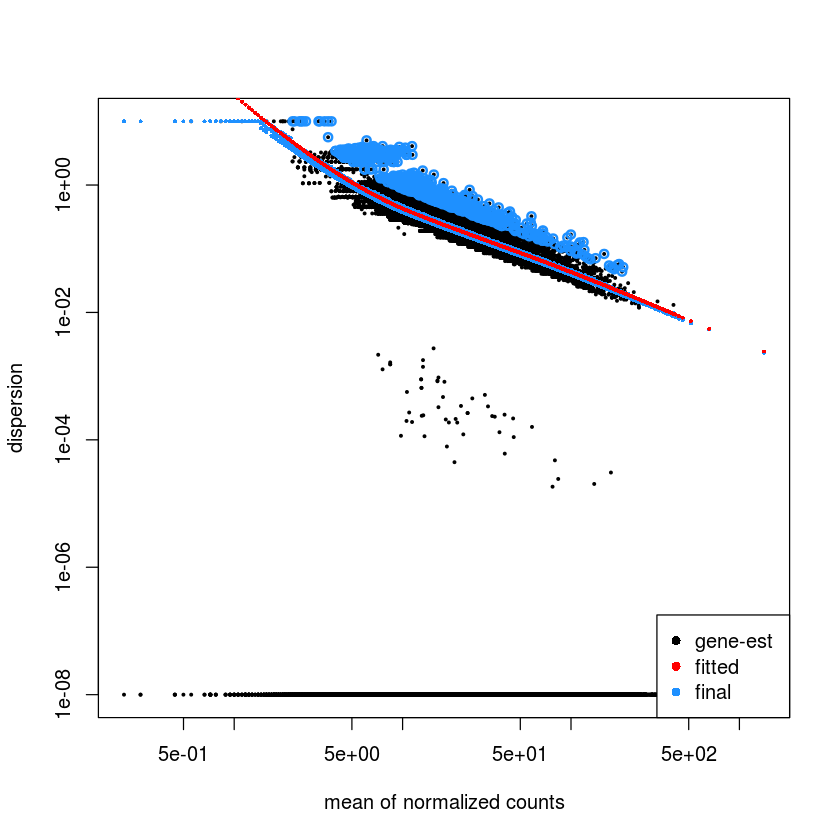

In [18]:
plotDispEsts(dds)

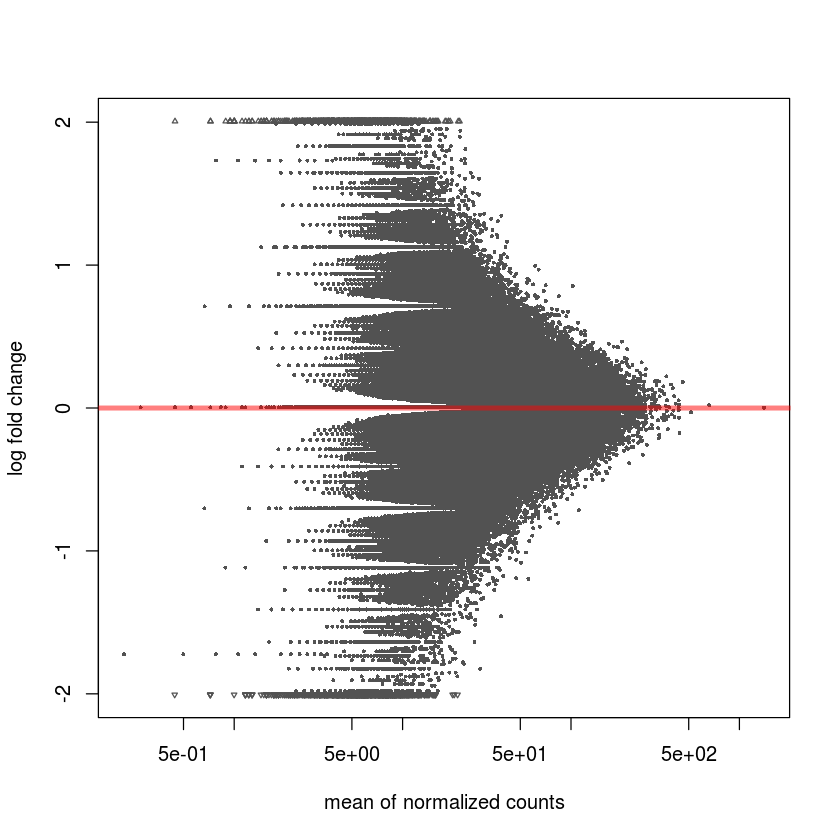

In [19]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [20]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221487 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221487 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221487 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [21]:

resultsNames(dds)

[1] "Intercept"               "Stiffness_Stiff_vs_Soft"
[3] "sv1"

In [22]:
res=results(dds,name="Stiffness_Stiff_vs_Soft",parallel=TRUE)

[1] 10


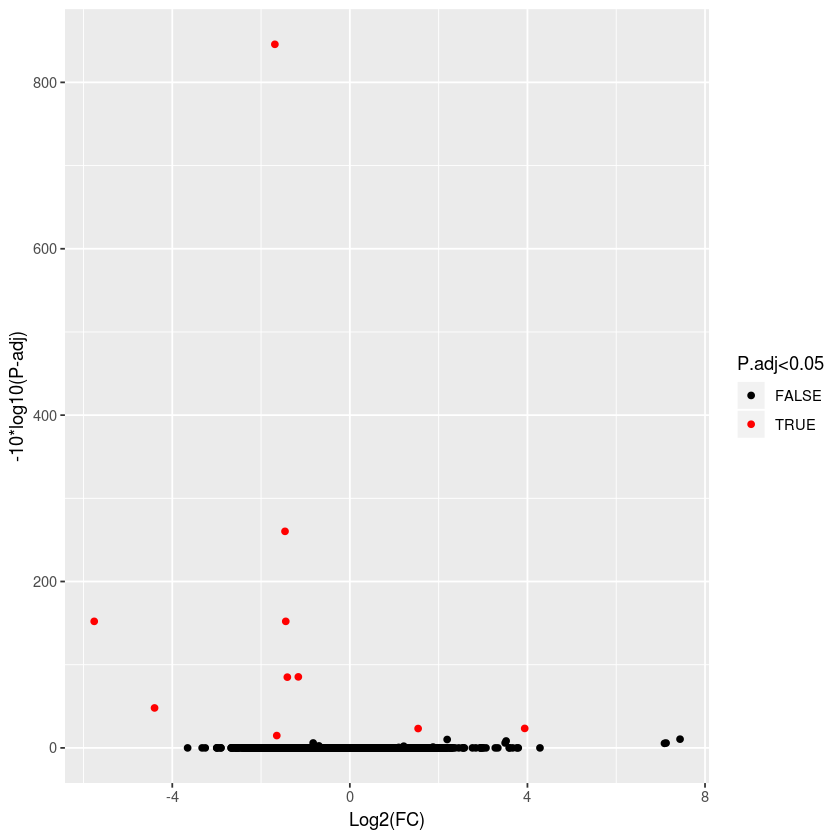

In [23]:
        res$logPadj=-10*log10(res$padj)
        res=as.data.frame(res)
        res=na.omit(res)
        numsig=sum(res$padj <= 0.05)
        sigsubset=res[res$padj<=0.05,]
        res$color=res$padj<=0.05
        ggplot(data=res,
        aes(x=res$log2FoldChange,
                 y=res$logPadj,
                 color=res$color))+
                 geom_point()+
                 xlab("Log2(FC)")+
                 ylab("-10*log10(P-adj)")+
                 scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05")
print(numsig)

## Visualizations 

In [27]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0 
lognorm=log2(normcounts+1)
data.pca=prcomp(t(lognorm))
#rld=assay(rlog(dds,blind=FALSE))
#data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [28]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,64
2,36
3,0
4,0


In [29]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


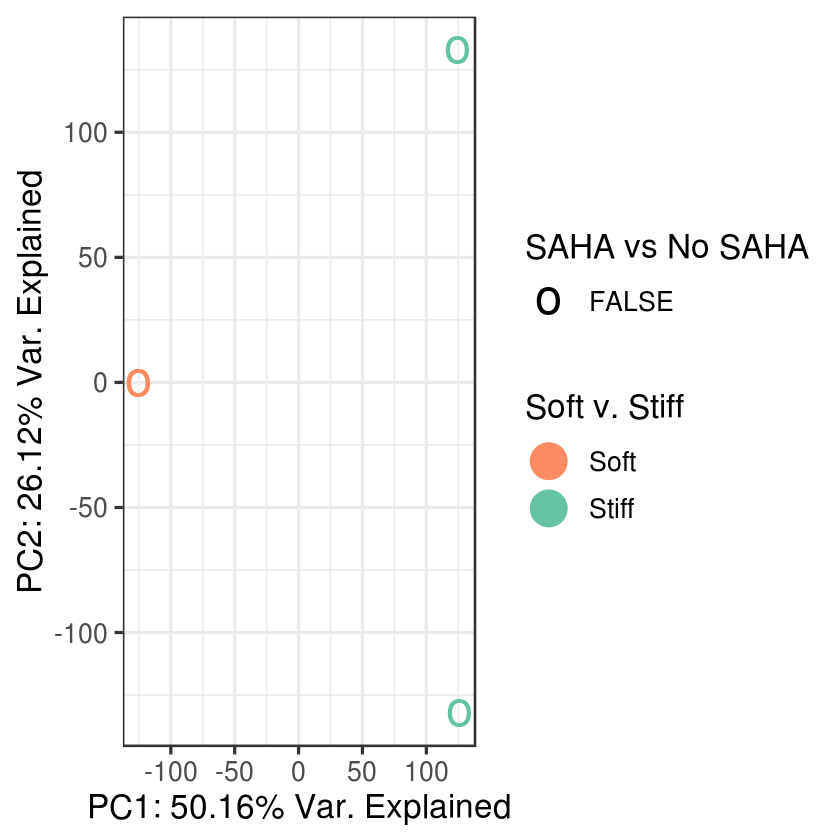

In [36]:
pca_df$Saha=c(FALSE,FALSE,FALSE,FALSE)
pca_df$Stiffness=c("Soft","Soft","Stiff","Stiff")
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Stiffness,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 50.16% Var. Explained")+
  ylab("PC2: 26.12% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="Soft v. Stiff")+
  scale_shape_manual(values=c("o","x"),name="SAHA vs No SAHA")
print(p1)
#svg("pca.no.saha.svg",width = 8, height = 4, pointsize = 12)
#print(p1)
#dev.off()

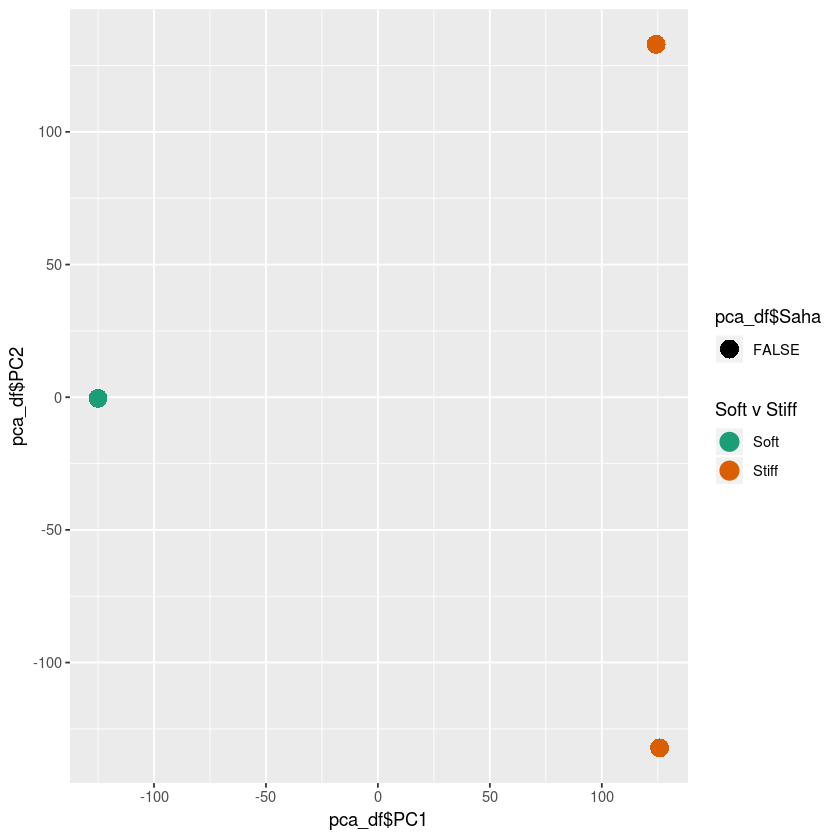

In [37]:
p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

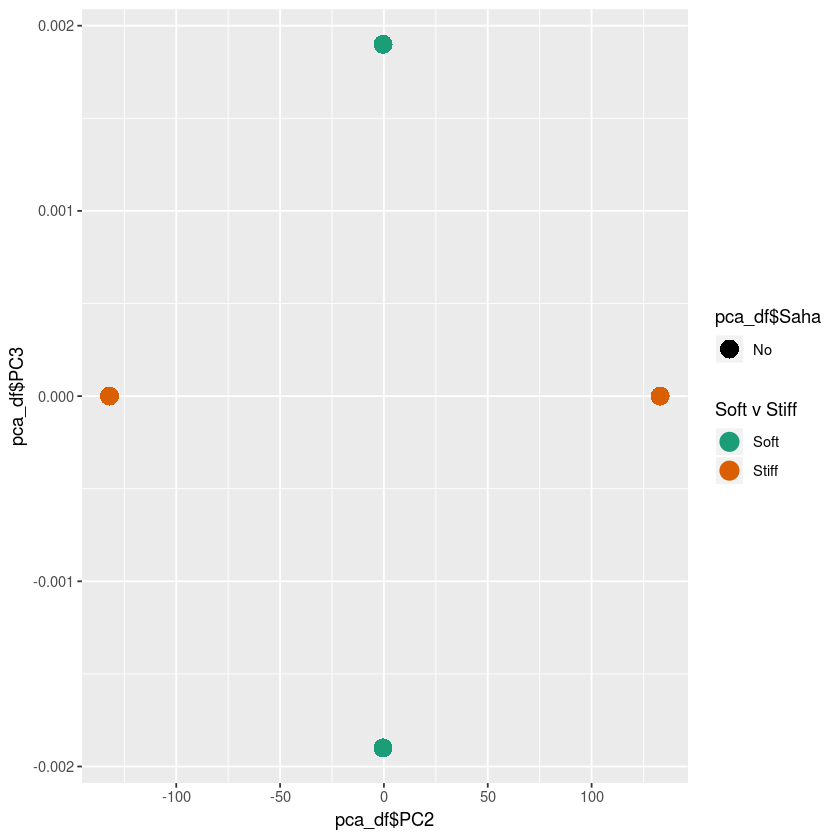

In [32]:
p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

## Get contributions to PC1 

In [33]:
pc1_loadings=sort(data.pca$rotation[, 1])

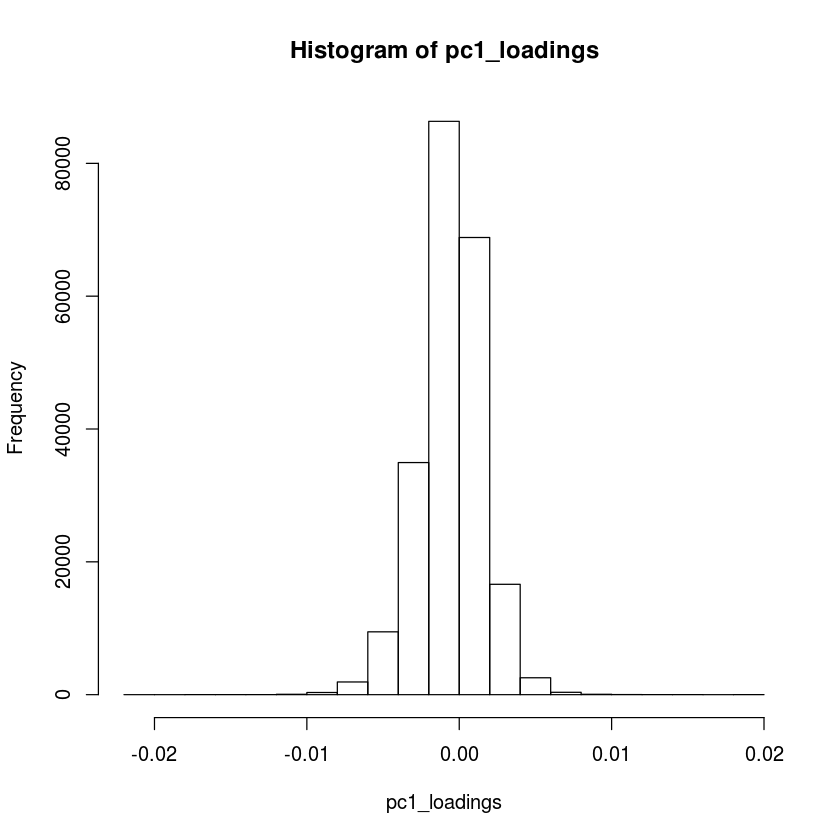

In [34]:
hist(pc1_loadings)

In [38]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

[1] 4527
[1] 1677


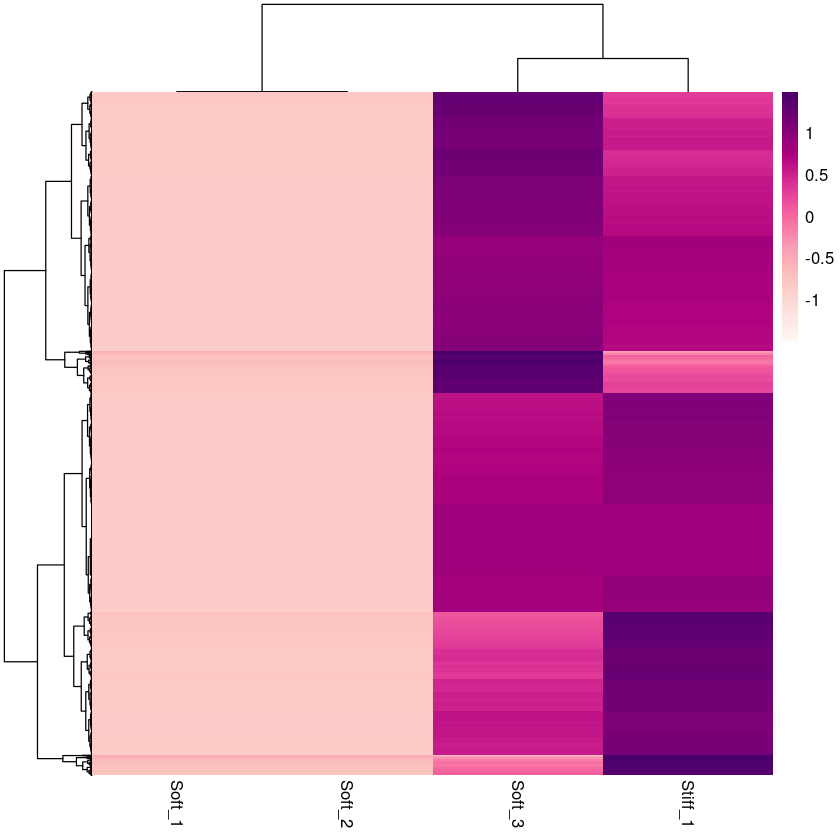

[1] 627


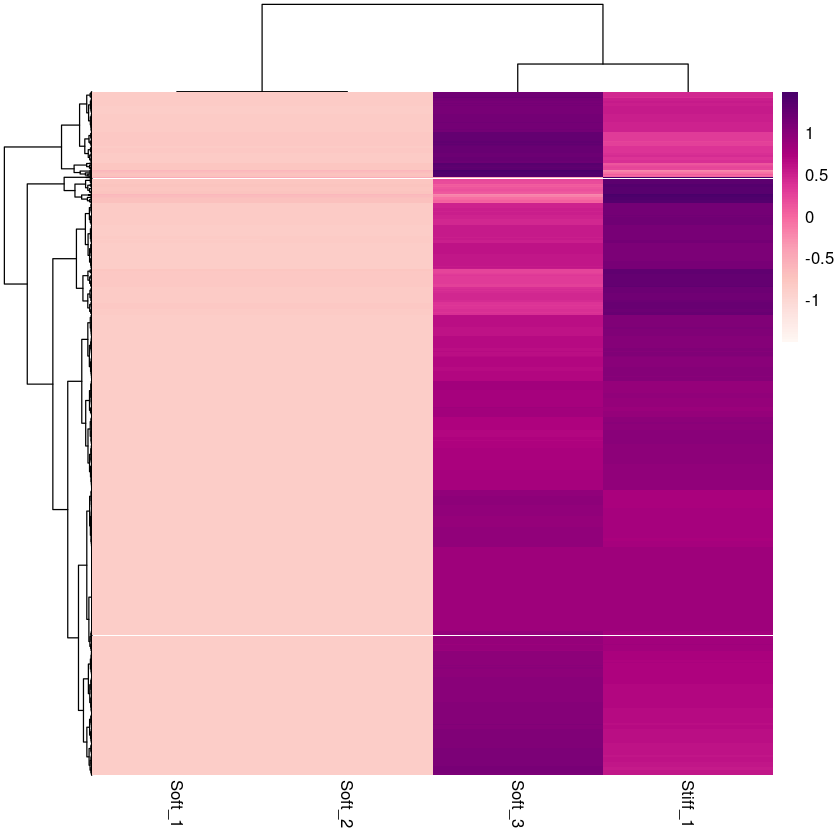

[1] 102


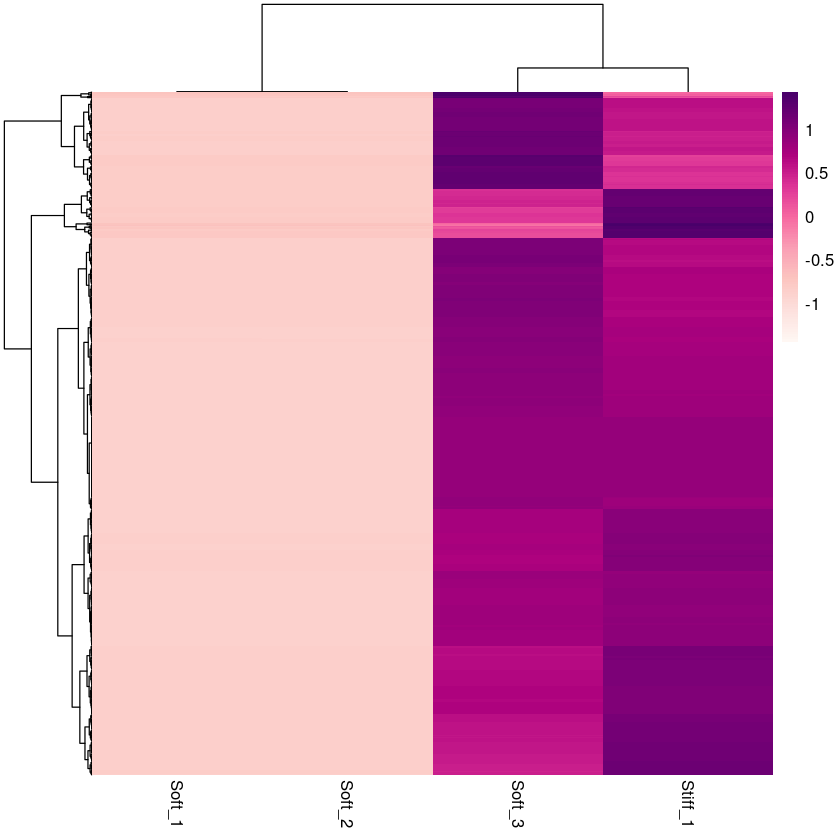

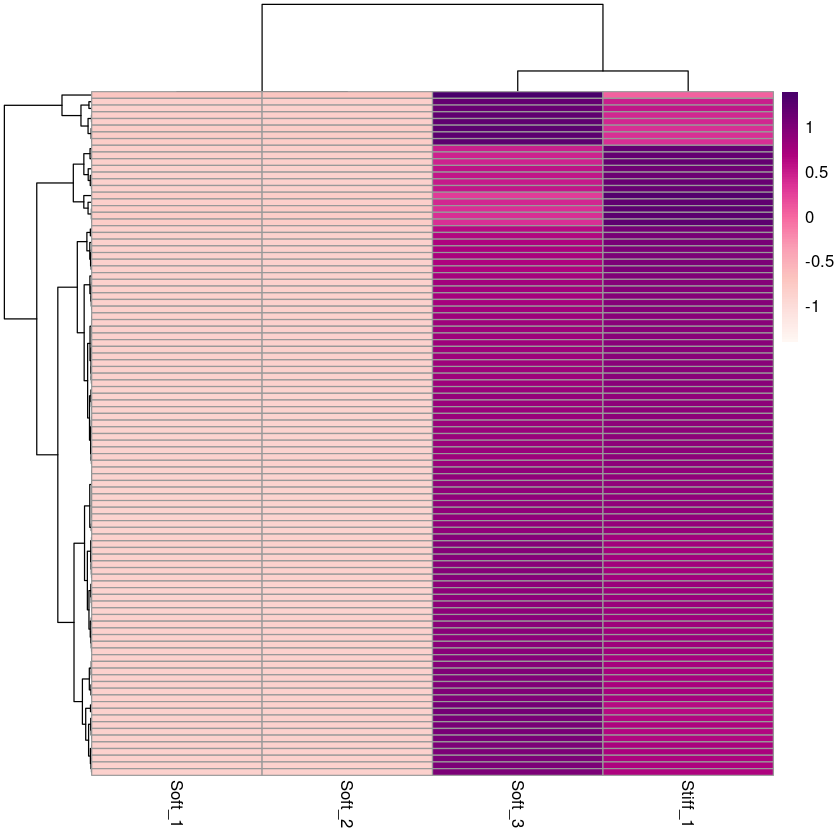

In [39]:
## Try cutoffs of 2, 2.5, 3, 4 st dev 
for(nsd in c(2,2.5,3,4))
{
    upper_bound=mean(pc1_loadings)+nsd*sd(pc1_loadings)
    toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))
    heatmap_indices=match(toselect,rownames(lognorm))
    head(heatmap_indices)
    forheatmap=lognorm[heatmap_indices,]
    outfname=paste("pseudorep.pc1.soft.stiff.highest.",nsd,'.tsv',sep='')
    write.table(forheatmap,file=outfname,row.names=TRUE,col.names=TRUE,sep='\t')
    print(nrow(forheatmap))
    p1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))
#    svg(paste("soft.stiff.zscores.",nsd,".svg",sep=""))
#    print(p1)
#    dev.off() 
}

## SP1 Peaks

In [358]:
strongest_sp1=read.table("../../homer//explicit_sp1_scan/sp1.txt",header=TRUE,sep='\t')


In [359]:
head(strongest_sp1)

PositionID,Offset,Sequence,Motif.Name,Strand,MotifScore
221467,-59,GGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,14.545522
221467,-39,AGGCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,10.792980
221467,14,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,46,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,96,CTGGGCGGAGCG,Sp1(Zf)/Promoter/Homer,-,9.031086
221467,-55,CTGGGCGGGCCC,Sp1(Zf)/Promoter/Homer,-,8.968299


In [360]:
for_heatmap=lognorm[strongest_sp1$PositionID,]

In [361]:
head(for_heatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874


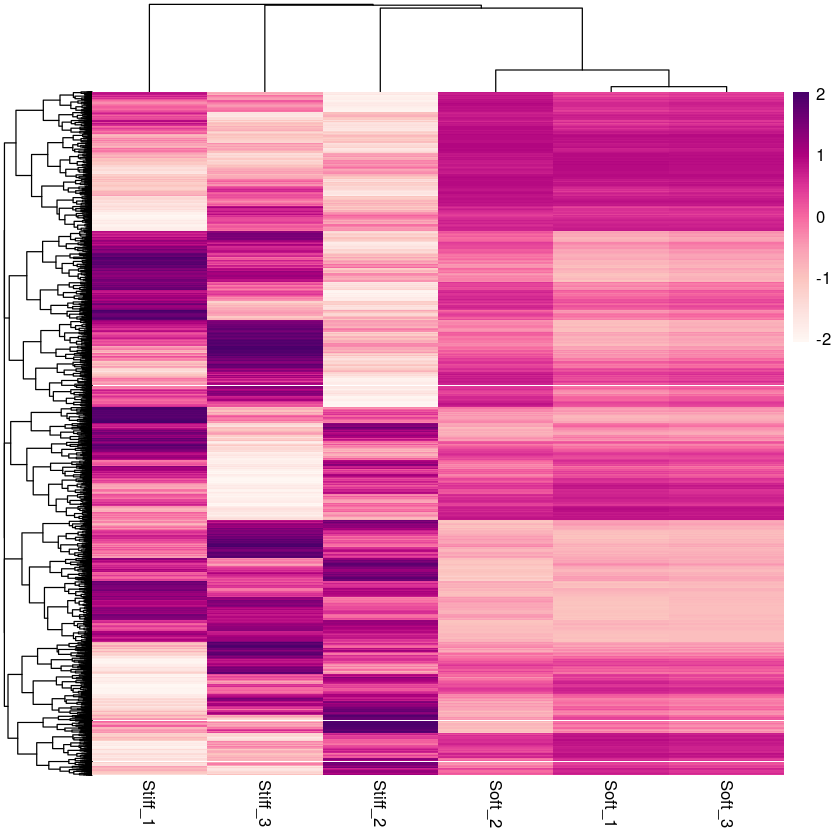

In [362]:
p1=pheatmap(for_heatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))

In [363]:
write.table(for_heatmap,file="peaks_with_sp1.bed",row.names=TRUE,col.names=TRUE,sep='\t',quote=FALSE)